# 23mer Regression analysis

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from itertools import cycle
import pickle

import sklearn.manifold
from sklearn.metrics import roc_curve, auc, r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.svm import LinearSVR, SVR
from sklearn.feature_selection import SelectFromModel, RFECV, VarianceThreshold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features import RFECV as yellowRFECV
from sklearn.kernel_ridge import KernelRidge

from math import log10, pow, log,sqrt
from statistics import mean
import scipy.stats as stats

In [43]:
#Load data
rownames = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/ML_REG_input23mer_7514.csv", "rb"),delimiter=',', dtype='str')[0,:]
names = np.asarray([_ for _ in rownames])
df = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/ML_REG_input23mer_7514.csv", "rb"),delimiter=',', usecols=range(1,rownames.shape[0]), dtype='float', skiprows=1)
sgRNA_seq = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/ML_REG_input23mer_7514.csv", "rb"),delimiter=',', usecols=0, dtype='str', skiprows=1)

#sort by sequence (not by activity/efficiency which is the response variable)
indx = sgRNA_seq.argsort()
df = df[indx,:]

#Standard scale non binary features
sc = StandardScaler()
df[:,1:26] = sc.fit_transform(df[:,1:26])

#Save standardized dataset
pd.DataFrame(np.column_stack((sgRNA_seq, df)), columns=names).to_csv("/home/pierre/Desktop/Position_Matrix/ML_REG_input23mer_7514-scaled.csv",index=False)

#Number of cpus to use for multithreading
n_cpu = 2

### RFECV

In [3]:
#Recursive Feature Elimination with Cross-Validation to remove the irrelevant features

modelnames = [
    "Linear Regression",
    "Linear SVR",
    "l1 Linear Regression",
    "Gradient-Boosted Decision Tree",
    "Random Forest"
]

model = [
    LinearRegression(n_jobs=n_cpu),
    LinearSVR(random_state=0),
    Ridge(random_state=0),
    GradientBoostingRegressor(random_state=0),
    RandomForestRegressor(random_state=0)
]

rfecv = dict()
models=dict()
datasets=dict()
supports = dict()
i=0
for name, clf in zip(modelnames, model):    
    model = RFECV(estimator=clf, 
                    cv=KFold(n_splits=10, random_state=0), 
                    scoring='r2', n_jobs=n_cpu)
    rfecv[i] = model
    model.fit(df[:,1:], df[:,0])

    X_new = model.transform(df[:,1:])
    sup = model.get_support(True)
    
    #Insert Column names
    X_new = pd.DataFrame(X_new, columns=names[1:][sup])

    print(X_new.shape)
    
    models[i] = model
    datasets[i] = X_new
    supports[i] = sup
    
    i+=1

(7514, 34)
(7514, 259)
(7514, 469)
(7514, 469)
(7514, 135)
(7514, 168)
(7514, 390)


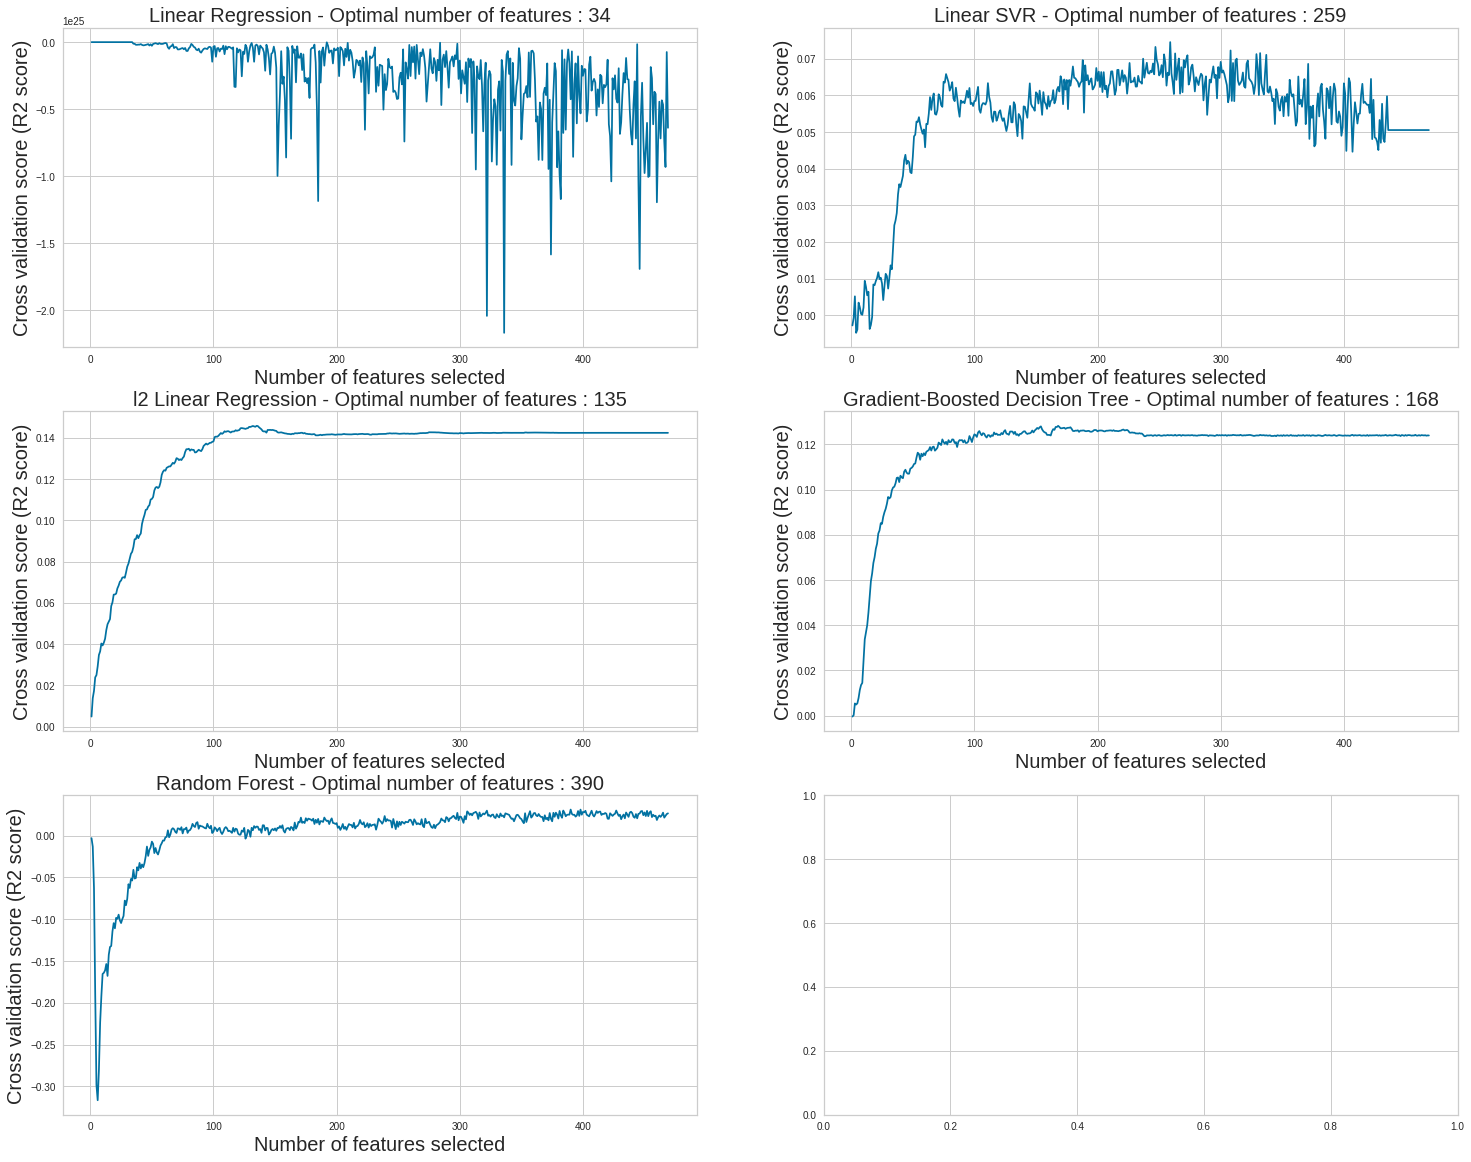

In [3]:
# RFECV to plot
modelnames = [
    "Linear Regression",
    "Linear SVR",
    "l2 Linear Regression",
    "Gradient-Boosted Decision Tree",
    "Random Forest"
]
n_groups = 5

# create plot
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(25,20))
plt.figure()

index = np.arange(n_groups)

for ax, i in zip(axes.flatten(),range(n_groups)):
    rfecv_model = rfecv[i]
    X_newL1 = datasets[i]

    ax.set_xlabel("Number of features selected", fontsize=20)
    ax.set_ylabel("Cross validation score (R2 score)", fontsize=20)
    ax.set_title("%s - Optimal number of features : %d" % (modelnames[i], X_newL1.shape[1]), fontsize=20)
    ax.plot(range(1, len(rfecv_model.grid_scores_) + 1), rfecv_model.grid_scores_)
    
plt.show()

In [5]:
data = {
    'rfecv': rfecv,
    'datasets': datasets,
    'supports': supports
}

pickle_out = open("23mer_RFECV.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close()

In [3]:
# # Uncomment to load the frecv and datasets
# pickle_in = open("23mer_RFECV.pickle","rb")
# p_load = pickle.load(pickle_in)

# rfecv = p_load['rfecv']
# datasets = p_load['datasets']
# supports = p_load['supports']

## Hyperparameter Optimization & Performance Evaluation

In [ ]:
# find the best hyperparameters for each model and evaluate its performance on the training set

models = [LinearRegression(),
          LinearSVR(),
          Ridge(),
          GradientBoostingRegressor(),
          RandomForestRegressor()
        ]

# set up params

tuned_parameters = [{},
                    {'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
                     'epsilon': [0,0.001,0.01,0.1,1],
                     'C': [0.001,0.01,0.1,1,10,100,1000]},
                    {'alpha': np.logspace(log10(10e-5),log10(1.5e5),100)},
                    {'n_estimators':[50,100,150,200],
                    'max_depth':[2,4,6,8,10],
                    'min_samples_split':[2,4],
                    'min_samples_leaf':[1,2],
                    'max_features':['auto','sqrt','log2']},
                    {'n_estimators':[50,100,150,200],
                     'max_depth':[2,4,6,8,10],
                     'min_samples_split':[2,4],
                     'min_samples_leaf':[1,2],
                     'max_features':['auto','sqrt','log2']}
                   ]
grid = dict()

for i in datasets :
    print(datasets[i].shape)
    grid[i] = dict()
    for j in range(len(models)):
        
        print(str(models[j]))
        print(str(tuned_parameters[j]))
        print()
        
        #Inner CV for parameter Optimization
        grid[i][j] = GridSearchCV(models[j], 
                                  tuned_parameters[j], 
                                  cv=KFold(n_splits=10, shuffle=True, random_state=i+j), 
                                  scoring='r2',n_jobs=n_cpu).fit(datasets[i], df[:,0])


(7514, 34)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
{}

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)
{'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], 'epsilon': [0, 0.001, 0.01, 0.1, 1], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.6733074

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.67330745e-01,
       1.19746487e+00, 1.48234937e+00, 1.83500969e+00, 2.27157015e+00,
       2

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.6733074

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.67330745e-01,
       1.19746487e+00, 1.48234937e+00, 1.83500969e+00, 2.27157015e+00,
       2

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.6733074

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.67330745e-01,
       1.19746487e+00, 1.48234937e+00, 1.83500969e+00, 2.27157015e+00,
       2

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
{'n_estimators': [50, 100, 150, 200], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2], 'max_features': ['auto', 'sqrt', 'log2']}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=

(7514, 390)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
{}

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)
{'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], 'epsilon': [0, 0.001, 0.01, 0.1, 1], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.8

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.6733074

/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pierre/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
{'alpha': array([1.00000000e-04, 1.23790635e-04, 1.53241213e-04, 1.89698271e-04,
       2.34828694e-04, 2.90695931e-04, 3.59854338e-04, 4.45465970e-04,
       5.51445153e-04, 6.82637457e-04, 8.45041242e-04, 1.04608192e-03,
       1.29495145e-03, 1.60302862e-03, 1.98439931e-03, 2.45650050e-03,
       3.04091757e-03, 3.76437117e-03, 4.65993897e-03, 5.76856804e-03,
       7.14094700e-03, 8.83982363e-03, 1.09428738e-02, 1.35462530e-02,
       1.67689926e-02, 2.07584424e-02, 2.56970076e-02, 3.18104889e-02,
       3.93784061e-02, 4.87467790e-02, 6.03439472e-02, 7.47001554e-02,
       9.24717967e-02, 1.14471424e-01, 1.41704903e-01, 1.75417399e-01,
       2.17150312e-01, 2.68811750e-01, 3.32763772e-01, 4.11930386e-01,
       5.09931241e-01, 6.31247121e-01, 7.81424819e-01, 9.67330745e-01,
       1.19746487e+00, 1.48234937e+00, 1.83500969e+00, 2.27157015e+00,
       2

In [ ]:
r2 = dict()
r2_adj = dict()
RMSE = dict()

for i in grid :
    print(datasets[i].shape)
    n =(datasets[i].shape[0])
    k =(datasets[i].shape[1])
    r2[i] = dict()
    r2_adj[i] = dict()
    RMSE[i] = dict()
    for j in range(len(grid[i])):
        print(str(grid[i][j]))
        
        scoreR2 = np.mean(cross_val_score(grid[i][j].best_estimator_, datasets[i], df[:,0], cv=KFold(n_splits=10, shuffle=True, random_state=i+j), scoring='r2', n_jobs=n_cpu))
        print('r2 = ',scoreR2)
        
        scoreR2_adj =1-(1-scoreR2)*(n-1)/(n-(k+1))
        print('r2_adj = ',scoreR2_adj)
        
        scoreRMSE = np.mean(cross_val_score(grid[i][j].best_estimator_, datasets[i], df[:,0], cv=KFold(n_splits=10, shuffle=True, random_state=i+j), scoring='neg_mean_squared_error', n_jobs=n_cpu))
        print('RMSE = ',sqrt(abs(scoreRMSE)))
        
        r2[i][j] = scoreR2
        r2_adj[i][j] = scoreR2_adj
        RMSE[i][j] = sqrt(abs(scoreRMSE))
        
        print('_____________')

In [ ]:
data = {
    'grid': grid,
    'r2': r2,
    'r2_adj': r2_adj,
    'RMSE': RMSE
}

pickle_out = open("23mer_GRID&Perf.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close()

In [17]:
# #Uncomment to load performance
# pickle_in = open("23mer_GRID&Perf.pickle","rb")
# p_load = pickle.load(pickle_in)

# grid = p_load['grid']
# r2 = p_load['r2']
# r2_adj = p_load['r2_adj']
# RMSE = p_load['RMSE']

# Plot the performance comparison on the training set

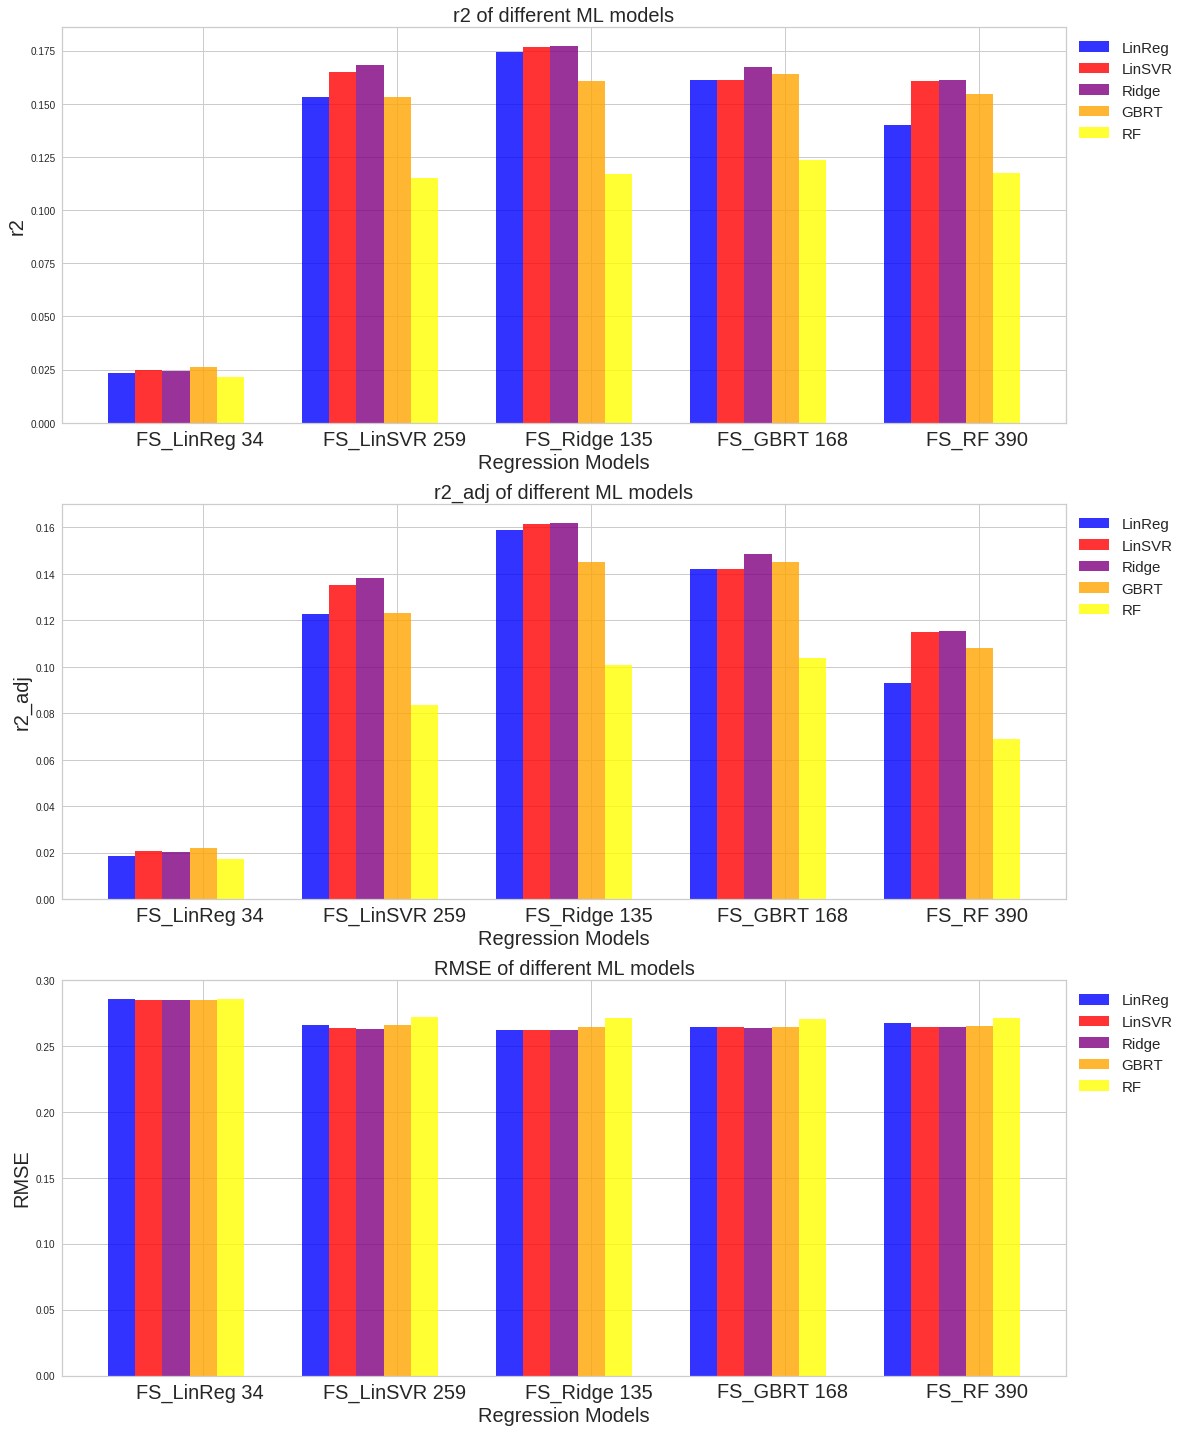

In [6]:
# data to plot
n_groups = 5
metrics = {'r2':r2, 'r2_adj':r2_adj, 'RMSE':RMSE}

# create plot
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(15,20))

index = np.arange(n_groups)
bar_width = 0.14
opacity = 0.8

i=0
for ax, v in zip(axes.flatten(),metrics.keys()):
    FS_LinReg = list()
    FS_LinSVR = list()
    FS_Ridge = list()
    FS_GBRT = list()
    FS_RF = list()
    for i in range(len(metrics[v])):
        FS_LinReg.append(metrics[v][i][0])
        FS_LinSVR.append(metrics[v][i][1])
        FS_Ridge.append(metrics[v][i][2])
        FS_GBRT.append(metrics[v][i][3])
        FS_RF.append(metrics[v][i][4])
    FS_LinReg = tuple(FS_LinReg)
    FS_LinSVR = tuple(FS_LinSVR)
    FS_Ridge = tuple(FS_Ridge)
    FS_GBRT = tuple(FS_GBRT)
    FS_RF = tuple(FS_RF)

    rects1 = ax.bar(index, FS_LinReg, bar_width, align = 'center',
                     alpha=opacity,
                     color='blue',
                     label='LinReg')

    rects2 = ax.bar(index + bar_width, FS_LinSVR, bar_width, align = 'center',
                     alpha=opacity,
                     color='red',
                     label='LinSVR')

    rects5 = ax.bar(index + bar_width*2, FS_Ridge, bar_width, align = 'center',
                     alpha=opacity,
                     color='purple',
                     label='Ridge')

    rects6 = ax.bar(index + bar_width*3, FS_GBRT, bar_width, align = 'center',
                     alpha=opacity,
                     color='orange',
                     label='GBRT')

    rects7 = ax.bar(index + bar_width*4, FS_RF, bar_width, align = 'center',
                     alpha=opacity,
                     color='yellow',
                     label='RF')

    ax.set_xlabel('Regression Models',fontsize=20)
    ax.set_ylabel(v,fontsize=20)
    ax.set_title('%s of different ML models' % v,fontsize=20)
    ax.set_xticks(index + bar_width*3)
    ax.set_xticklabels(['FS_LinReg %i ' % datasets[0].shape[1], 
                        'FS_LinSVR %i ' % datasets[1].shape[1], 
                        'FS_Ridge %i ' % datasets[2].shape[1], 
                        'FS_GBRT %i ' % datasets[3].shape[1],
                        'FS_RF %i ' % datasets[4].shape[1]], fontsize=20)
    ax.legend(fontsize=15,loc='upper right', bbox_to_anchor=(1.12, 1), ncol=1)
    i+=1

plt.tight_layout()
plt.show()

## Save Best Model

In [16]:
data = {
    'model': grid[2][2].best_estimator_,
    'df_indexes': supports[2]
}

pickle_out = open("23mer_135FS_Ridge_REGmodel.pickle","wb")
pickle.dump(data, pickle_out)
pickle_out.close()

In [4]:
# # Uncomment ot lead the best model

# pickle_in = open("23mer_135FS_Ridge_REGmodel.pickle","rb")
# p_load = pickle.load(pickle_in)
# Model = p_load['model']
# idx = p_load['df_indexes']

# Residual plot Analysis

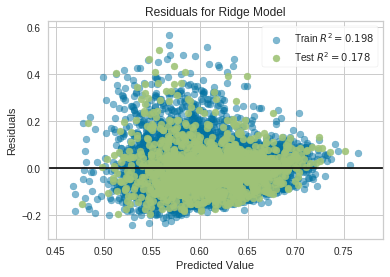

In [44]:
# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(datasets[2], df[:,0], test_size=0.2)

model = Model
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()  

## feature importance

In [33]:
df_importance = pd.DataFrame(grid[2][3].best_estimator_.feature_importances_, datasets[2].columns)
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(df_importance)

nbCA    0.016404
nbCG    0.030317
nbGC    0.016917
A1      0.005216
A2      0.008541
A5      0.008887
A8      0.013017
A13     0.007624
A19     0.004306
C2      0.011496
C4      0.015049
C5      0.009254
C9      0.007652
C11     0.009257
C15     0.012362
C16     0.011643
C17     0.009808
C20     0.010339
C21     0.009273
G7      0.007115
G8      0.009912
G9      0.013020
G11     0.005764
G12     0.012057
G13     0.016924
G14     0.011364
G20     0.013588
T11     0.010723
T12     0.005800
T13     0.013363
T18     0.007499
AA1     0.007422
AA2     0.002248
AA4     0.003063
AA6     0.006499
AA9     0.002390
AA15    0.004921
AA17    0.004854
AA18    0.006974
AA20    0.005848
AC6     0.004402
AC17    0.011001
AC20    0.005062
AG4     0.005228
AG6     0.009353
AG11    0.006295
AG12    0.010167
AG18    0.003876
AG20    0.002922
AT5     0.004148
AT8     0.007509
AT10    0.003487
AT11    0.005624
AT15    0.007428
CA1     0.003351
CA6     0.009948
CA8     0.005634
CA9     0.006568
CA10    0.0042

In [22]:
pos_indep_order1 = 0
print(pos_indep_order1)
pos_dep_order1 = sum(df_importance.iloc[3:31][0])
print(pos_dep_order1)

pos_indep_order2 = sum(df_importance.iloc[0:3][0])
print(pos_indep_order2)
pos_dep_order2 = sum(df_importance.iloc[31:][0])
print(pos_dep_order2)

#PAM_bounds = sum(df_importance.iloc[197:][0])
#print(PAM_bounds)

0
0.280852580393375
0.0636380138291043
0.6555094057775206


0.9999999999999999


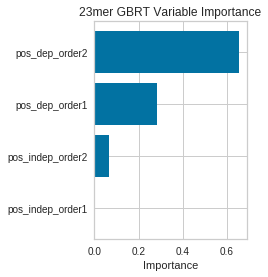

In [27]:
print(sum((pos_indep_order1,pos_indep_order2,pos_dep_order1,pos_dep_order2
           #,PAM_bounds
          )))

pos = np.arange(4) + .5
plt.subplot(1, 2, 2)
plt.barh(pos,(pos_indep_order1,pos_indep_order2,pos_dep_order1,pos_dep_order2
              #,PAM_bounds
             ), align='center')
plt.yticks(pos, ('pos_indep_order1','pos_indep_order2','pos_dep_order1','pos_dep_order2'
                 #,'PAM_bounds'
                ))
plt.xlabel('Importance')
plt.title('23mer GBRT Variable Importance')
plt.show()

## Guide efficiency prediction Performance

### Training set

In [20]:
scoredf = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/Analysis-23mer_sgRNA_7514predictions.csv", "rb"), delimiter=',', usecols=(1,2), dtype='float', skiprows=1)
indx = scoredf[:,1].argsort()
scoredf = scoredf[indx,:]


dic_scores = dict()
k=0
for i in np.arange(0,1,0.1):
    dic_scores[k]= scoredf[np.where((scoredf[:,1]>=i) & (scoredf[:,1]<i+0.1)),]
    k+=1
#print(dic_scores)


npRed = list()
npOrange = list()
npYellow = list()
npGreen = list()
for i in dic_scores:
    npRed.append(len(np.where((dic_scores[i][0][:,0]>=0) & (dic_scores[i][0][:,0]<0.25))[0])/len(dic_scores[i][0][:,0]))
    npOrange.append(len(np.where((dic_scores[i][0][:,0]>=0.25) & (dic_scores[i][0][:,0]<0.5))[0])/len(dic_scores[i][0][:,0]))
    npYellow.append(len(np.where((dic_scores[i][0][:,0]>=0.5) & (dic_scores[i][0][:,0]<0.75))[0])/len(dic_scores[i][0][:,0]))
    npGreen.append(len(np.where((dic_scores[i][0][:,0]>=0.75) & (dic_scores[i][0][:,0]<1.0))[0])/len(dic_scores[i][0][:,0]))

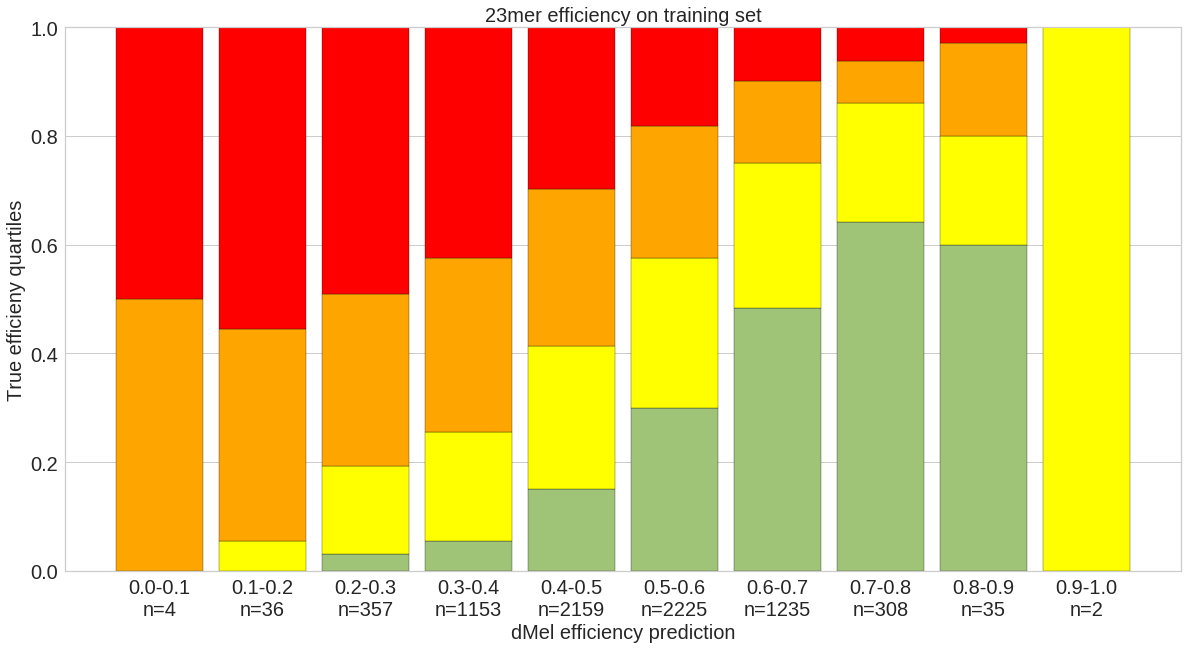

In [21]:
# Data
r = [0,1,2,3,4,5,6,7,8,9]
raw_data = {'greenBars': npGreen, 
            'yellowBars': npYellow,
            'orangeBars': npOrange,
            'redBars': npRed
           }
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k+l for i,j,k,l in zip(df['greenBars'], df['yellowBars'], df['orangeBars'], df['redBars'])]
greenBars = [i / j  for i,j in zip(df['greenBars'], totals)]
yellowBars = [i / j for i,j in zip(df['yellowBars'], totals)]
orangeBars = [i / j  for i,j in zip(df['orangeBars'], totals)]
redBars = [i / j for i,j in zip(df['redBars'], totals)]
 
# plot
plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
barWidth = 0.85
names = ('0.0-0.1\nn=%s' % len(dic_scores[0][0][:,0]),
         '0.1-0.2\nn=%s' % len(dic_scores[1][0][:,0]),
         '0.2-0.3\nn=%s' % len(dic_scores[2][0][:,0]),
         '0.3-0.4\nn=%s' % len(dic_scores[3][0][:,0]),
         '0.4-0.5\nn=%s' % len(dic_scores[4][0][:,0]),
         '0.5-0.6\nn=%s' % len(dic_scores[5][0][:,0]),
         '0.6-0.7\nn=%s' % len(dic_scores[6][0][:,0]),
         '0.7-0.8\nn=%s' % len(dic_scores[7][0][:,0]),
         '0.8-0.9\nn=%s' % len(dic_scores[8][0][:,0]),
         '0.9-1.0\nn=%s' % len(dic_scores[9][0][:,0]))
# Create green Bars
plt.bar(r, greenBars, color='g', edgecolor='black', width=barWidth)
# Create yellow Bars
plt.bar(r, yellowBars, bottom=greenBars, color='yellow', edgecolor='black', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=[i+j for i,j in zip(greenBars, yellowBars)], color='orange', edgecolor='black', width=barWidth)
# Create red Bars
plt.bar(r, redBars, bottom=[i+j+k for i,j,k in zip(greenBars, yellowBars,orangeBars)], color='red', edgecolor='black', width=barWidth)


# Custom x axis
plt.xticks(r, names)
plt.title("23mer efficiency on training set")
plt.xlabel("dMel efficiency prediction", fontsize=20)
plt.ylabel("True efficieny quartiles", fontsize=20)
 
# Show graphic
plt.show()

### Testing set

In [16]:
scoredf = np.loadtxt(open("/home/pierre/Desktop/Position_Matrix/Analysis-Test_Set_Droso.csv", "rb"), delimiter=',', usecols=(4,6), dtype='float', skiprows=1)
indx = scoredf[:,1].argsort()
scoredf = scoredf[indx,:]


dic_scores = dict()
k=0
for i in np.arange(0.1,0.9,0.1):
    dic_scores[k]= scoredf[np.where((scoredf[:,1]>=i) & (scoredf[:,1]<i+0.1)),]
    k+=1
#print(dic_scores)


npRed = list()
npOrange = list()
npYellow = list()
npGreen = list()
for i in dic_scores:
    npRed.append(len(np.where((dic_scores[i][0][:,0]>=0) & (dic_scores[i][0][:,0]<0.25))[0])/len(dic_scores[i][0][:,0]))
    npOrange.append(len(np.where((dic_scores[i][0][:,0]>=0.25) & (dic_scores[i][0][:,0]<0.5))[0])/len(dic_scores[i][0][:,0]))
    npYellow.append(len(np.where((dic_scores[i][0][:,0]>=0.5) & (dic_scores[i][0][:,0]<0.75))[0])/len(dic_scores[i][0][:,0]))
    npGreen.append(len(np.where((dic_scores[i][0][:,0]>=0.75) & (dic_scores[i][0][:,0]<1.0))[0])/len(dic_scores[i][0][:,0]))

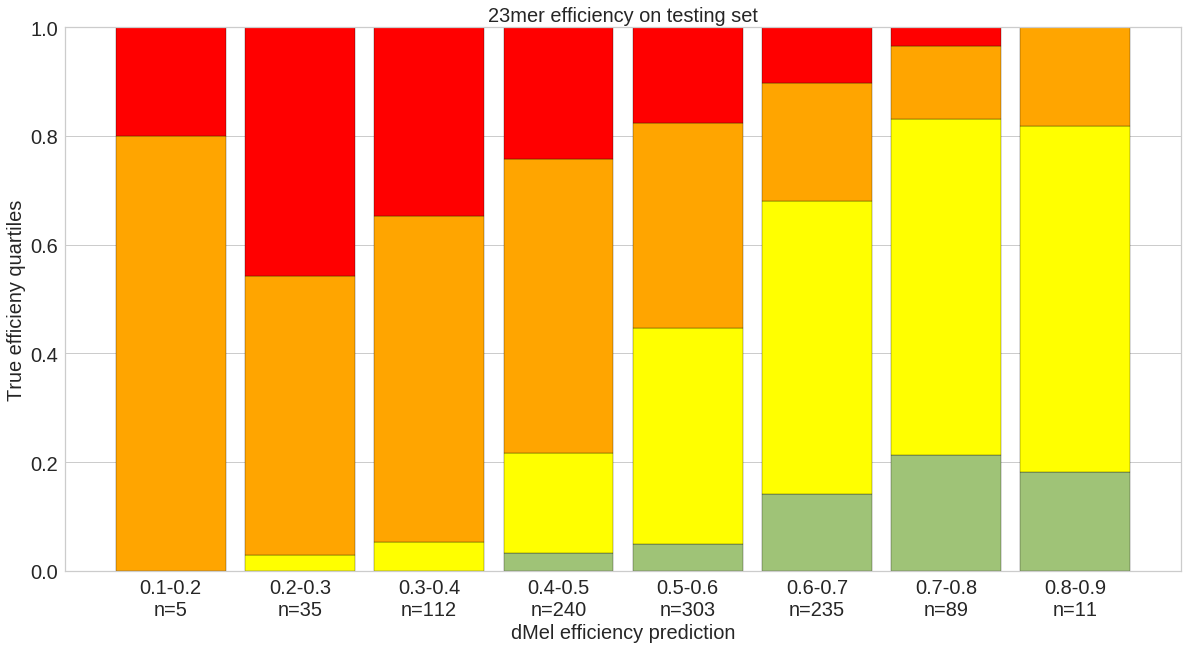

In [18]:
# Data
r = [1,2,3,4,5,6,7,8]
raw_data = {'greenBars': npGreen, 
            'yellowBars': npYellow,
            'orangeBars': npOrange,
            'redBars': npRed
           }
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k+l for i,j,k,l in zip(df['greenBars'], df['yellowBars'], df['orangeBars'], df['redBars'])]
greenBars = [i / j  for i,j in zip(df['greenBars'], totals)]
yellowBars = [i / j for i,j in zip(df['yellowBars'], totals)]
orangeBars = [i / j  for i,j in zip(df['orangeBars'], totals)]
redBars = [i / j for i,j in zip(df['redBars'], totals)]
 
# plot
plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
barWidth = 0.85
names = (
         '0.1-0.2\nn=%s' % len(dic_scores[0][0][:,0]),
         '0.2-0.3\nn=%s' % len(dic_scores[1][0][:,0]),
         '0.3-0.4\nn=%s' % len(dic_scores[2][0][:,0]),
         '0.4-0.5\nn=%s' % len(dic_scores[3][0][:,0]),
         '0.5-0.6\nn=%s' % len(dic_scores[4][0][:,0]),
         '0.6-0.7\nn=%s' % len(dic_scores[5][0][:,0]),
         '0.7-0.8\nn=%s' % len(dic_scores[6][0][:,0]),
         '0.8-0.9\nn=%s' % len(dic_scores[7][0][:,0]))
# Create green Bars
plt.bar(r, greenBars, color='g', edgecolor='black', width=barWidth)
# Create yellow Bars
plt.bar(r, yellowBars, bottom=greenBars, color='yellow', edgecolor='black', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=[i+j for i,j in zip(greenBars, yellowBars)], color='orange', edgecolor='black', width=barWidth)
# Create red Bars
plt.bar(r, redBars, bottom=[i+j+k for i,j,k in zip(greenBars, yellowBars,orangeBars)], color='red', edgecolor='black', width=barWidth)


# Custom x axis
plt.xticks(r, names)
plt.title("23mer efficiency on testing set")
plt.xlabel("dMel efficiency prediction", fontsize=20)
plt.ylabel("True efficieny quartiles", fontsize=20)
 
# Show graphic
plt.show()